In [5]:
from typing import Callable, Iterator, Tuple
import chex
import jax

import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import jaxopt
import pandas as pd

from math import pi, log
from ripple.typing import Array
from scipy.optimize import minimize, minimize_scalar

from numpy import random, abs
from ripple.waveforms import IMRPhenomD, IMRPhenomD_utils
from ripple.waveforms.IMRPhenomD import *
from ripple.waveforms.IMRPhenomD_utils import get_coeffs, get_transition_frequencies
from ripple import ms_to_Mc_eta, Mc_eta_to_ms
from jax import grad, vmap, scipy
from functools import partial
import time

PhenomD_coeff_table = jnp.array(
    [
        [  # rho1 (element 0)
            3931.8979897196696,
            -17395.758706812805,
            3132.375545898835,
            343965.86092361377,
            -1.2162565819981997e6,
            -70698.00600428853,
            1.383907177859705e6,
            -3.9662761890979446e6,
            -60017.52423652596,
            803515.1181825735,
            -2.091710365941658e6,
        ],
        [  # rho2 (element 1)
            -40105.47653771657,
            112253.0169706701,
            23561.696065836168,
            -3.476180699403351e6,
            1.137593670849482e7,
            754313.1127166454,
            -1.308476044625268e7,
            3.6444584853928134e7,
            596226.612472288,
            -7.4277901143564405e6,
            1.8928977514040343e7,
        ],
        [  # rho3 (element 2)
            83208.35471266537,
            -191237.7264145924,
            -210916.2454782992,
            8.71797508352568e6,
            -2.6914942420669552e7,
            -1.9889806527362722e6,
            3.0888029960154563e7,
            -8.390870279256162e7,
            -1.4535031953446497e6,
            1.7063528990822166e7,
            -4.2748659731120914e7,
        ],
        [  # v2 (element 3)
            0.8149838730507785,
            2.5747553517454658,
            1.1610198035496786,
            -2.3627771785551537,
            6.771038707057573,
            0.7570782938606834,
            -2.7256896890432474,
            7.1140380397149965,
            0.1766934149293479,
            -0.7978690983168183,
            2.1162391502005153,
        ],
        [  # gamma1 (element 4)
            0.006927402739328343,
            0.03020474290328911,
            0.006308024337706171,
            -0.12074130661131138,
            0.26271598905781324,
            0.0034151773647198794,
            -0.10779338611188374,
            0.27098966966891747,
            0.0007374185938559283,
            -0.02749621038376281,
            0.0733150789135702,
        ],
        [  # gamma2 (element 5)
            1.010344404799477,
            0.0008993122007234548,
            0.283949116804459,
            -4.049752962958005,
            13.207828172665366,
            0.10396278486805426,
            -7.025059158961947,
            24.784892370130475,
            0.03093202475605892,
            -2.6924023896851663,
            9.609374464684983,
        ],
        [  # gamma3 (element 6)
            1.3081615607036106,
            -0.005537729694807678,
            -0.06782917938621007,
            -0.6689834970767117,
            3.403147966134083,
            -0.05296577374411866,
            -0.9923793203111362,
            4.820681208409587,
            -0.006134139870393713,
            -0.38429253308696365,
            1.7561754421985984,
        ],
        [  # sig1 (element 7)
            2096.551999295543,
            1463.7493168261553,
            1312.5493286098522,
            18307.330017082117,
            -43534.1440746107,
            -833.2889543511114,
            32047.31997183187,
            -108609.45037520859,
            452.25136398112204,
            8353.439546391714,
            -44531.3250037322,
        ],
        [  # sig2 (element 8)
            -10114.056472621156,
            -44631.01109458185,
            -6541.308761668722,
            -266959.23419307504,
            686328.3229317984,
            3405.6372187679685,
            -437507.7208209015,
            1.6318171307344697e6,
            -7462.648563007646,
            -114585.25177153319,
            674402.4689098676,
        ],
        [  # sig3 (element 9)
            22933.658273436497,
            230960.00814979506,
            14961.083974183695,
            1.1940181342318142e6,
            -3.1042239693052764e6,
            -3038.166617199259,
            1.8720322849093592e6,
            -7.309145012085539e6,
            42738.22871475411,
            467502.018616601,
            -3.064853498512499e6,
        ],
        [  # sig4 (element 10)
            -14621.71522218357,
            -377812.8579387104,
            -9608.682631509726,
            -1.7108925257214056e6,
            4.332924601416521e6,
            -22366.683262266528,
            -2.5019716386377467e6,
            1.0274495902259542e7,
            -85360.30079034246,
            -570025.3441737515,
            4.396844346849777e6,
        ],
        [  # beta1 (element 11)
            97.89747327985583,
            -42.659730877489224,
            153.48421037904913,
            -1417.0620760768954,
            2752.8614143665027,
            138.7406469558649,
            -1433.6585075135881,
            2857.7418952430758,
            41.025109467376126,
            -423.680737974639,
            850.3594335657173,
        ],
        [  # beta2 (element 12)
            -3.282701958759534,
            -9.051384468245866,
            -12.415449742258042,
            55.4716447709787,
            -106.05109938966335,
            -11.953044553690658,
            76.80704618365418,
            -155.33172948098394,
            -3.4129261592393263,
            25.572377569952536,
            -54.408036707740465,
        ],
        [  # beta3 (element 13)
            -0.000025156429818799565,
            0.000019750256942201327,
            -0.000018370671469295915,
            0.000021886317041311973,
            0.00008250240316860033,
            7.157371250566708e-6,
            -0.000055780000112270685,
            0.00019142082884072178,
            5.447166261464217e-6,
            -0.00003220610095021982,
            0.00007974016714984341,
        ],
        [  # a1 (element 14)
            43.31514709695348,
            638.6332679188081,
            -32.85768747216059,
            2415.8938269370315,
            -5766.875169379177,
            -61.85459307173841,
            2953.967762459948,
            -8986.29057591497,
            -21.571435779762044,
            981.2158224673428,
            -3239.5664895930286,
        ],
        [  # a2 (element 15)
            -0.07020209449091723,
            -0.16269798450687084,
            -0.1872514685185499,
            1.138313650449945,
            -2.8334196304430046,
            -0.17137955686840617,
            1.7197549338119527,
            -4.539717148261272,
            -0.049983437357548705,
            0.6062072055948309,
            -1.682769616644546,
        ],
        [  # a3 (element 16)
            9.5988072383479,
            -397.05438595557433,
            16.202126189517813,
            -1574.8286986717037,
            3600.3410843831093,
            27.092429659075467,
            -1786.482357315139,
            5152.919378666511,
            11.175710130033895,
            -577.7999423177481,
            1808.730762932043,
        ],
        [  # a4 (element 17)
            -0.02989487384493607,
            1.4022106448583738,
            -0.07356049468633846,
            0.8337006542278661,
            0.2240008282397391,
            -0.055202870001177226,
            0.5667186343606578,
            0.7186931973380503,
            -0.015507437354325743,
            0.15750322779277187,
            0.21076815715176228,
        ],
        [  # a5 (element 18)
            0.9974408278363099,
            -0.007884449714907203,
            -0.059046901195591035,
            1.3958712396764088,
            -4.516631601676276,
            -0.05585343136869692,
            1.7516580039343603,
            -5.990208965347804,
            -0.017945336522161195,
            0.5965097794825992,
            -2.0608879367971804,
        ],
    ]
)


"""
Various constants, all in SI units.
"""

EulerGamma = 0.577215664901532860606512090082402431

MSUN = 1.9884099021470415e30  # kg
"""Solar mass"""

G = 6.67430e-11  # m^3 / kg / s^2
"""Newton's gravitational constant"""

C = 299792458.0  # m / s
"""Speed of light"""

gt = G * MSUN / (C ** 3.0)
"""
G MSUN / C^3 in seconds
"""

m_per_Mpc = 3.085677581491367278913937957796471611e22
"""
Meters per Mpc.
"""

#amp_scale = PhenomD_coeff_table[:7]
#phase_scale = PhenomD_coeff_table[7:]

'\nMeters per Mpc.\n'

In [6]:
@jax.jit
def _get_coeffs(theta: Array, table: Array) -> Array:
    # Retrives the coefficients needed to produce the waveform

    m1, m2, chi1, chi2 = theta
    m1_s = m1 * gt
    m2_s = m2 * gt
    M_s = m1_s + m2_s
    eta = m1_s * m2_s / (M_s ** 2.0)

    # Definition of chiPN from lalsuite
    chi_s = (chi1 + chi2) / 2.0
    chi_a = (chi1 - chi2) / 2.0
    seta = (1 - 4 * eta) ** (1 / 2)
    chiPN = chi_s * (1 - 76 * eta / 113) + seta * chi_a

    coeff = (
        table[:, 0]
        + table[:, 1] * eta
        + (chiPN - 1.0)
        * (
            table[:, 2]
            + table[:, 3] * eta
            + table[:, 4] * (eta ** 2.0)
        )
        + (chiPN - 1.0) ** 2.0
        * (
            table[:, 5]
            + table[:, 6] * eta
            + table[:, 7] * (eta ** 2.0)
        )
        + (chiPN - 1.0) ** 3.0
        * (
            table[:, 8]
            + table[:, 9] * eta
            + table[:, 10] * (eta ** 2.0)
        )
    )

    # FIXME: Change to dictionary lookup
    return coeff
#print(_get_coeffs(theta_intrinsic[0], PhenomD_coeff_table) - get_coeffs(theta_intrinsic[0]))

In [7]:
f_start = 16.0
f_end = 512.0
delta_f = 0.01
fs = jnp.arange(f_start, f_end, delta_f)

f_sep = 160
f_list = jnp.array(fs[0::f_sep])

theta_intrinsic = jnp.array([
                   # [25.0, 25.0, -0.95, -0.95], 
                   # [25.0, 25.0, -0.60, -0.60], 
                   [25.0, 25.0, 0.00, 0.00], 
                #    [25.0, 25.0, 0.60, 0.60], 
                #    [25.0, 25.0, 0.98, 0.98], 
                #    [40.0, 10.0, -0.75, -0.75],
                #    [40.0, 10.0, -0.50, -0.50],
                #    [40.0, 10.0, 0.00, 0.00],
                   [40.0, 10.0, 0.50, 0.50],
                #    [40.0, 10.0, 0.75, 0.75],
                #    [44.4, 5.6, -0.85, -0.85],
                   [44.4, 5.6, -0.50, 0.00],
                #    [44.4, 5.6, 0.00, 0.00],
                #    [44.4, 5.6, 0.50, 0.00],
                #    [44.4, 5.6, 0.85, 0.85],
                #    [44.4, 5.6, -0.85, -0.85],
                #    [47.4, 2.6, -0.80, 0.00],
                #    [47.4, 2.6, -0.40, 0.00],
                #    [47.4, 2.6, 0.00, 0.00],
                #    [47.4, 2.6, 0.40, 0.00]
                  ])
theta_extrinsic = jnp.array([440.0, 0.01, 0.0])

print(theta_intrinsic)

[[25.  25.   0.   0. ]
 [40.  10.   0.5  0.5]
 [44.4  5.6 -0.5  0. ]]


In [8]:
@jax.jit
def inner(h1: Array, h2: Array, df):
    cross_multi = jnp.real(h1 * jnp.conj(h2))
    return sum(jnp.abs(cross_multi) * df)

@jax.jit
def mismatch(h1: Array, h2: Array, df):
    return 1 - (inner(h1, h2, df) / jnp.sqrt(inner(h1, h1, df) * inner(h2, h2, df)))

@jax.jit
def loss(truncated_norm: Array, other: Array, intrin: Array, extrin: Array, f: Array) -> Array:
    test_lambdas = jnp.concatenate([truncated_norm * truncated_scale, other], axis=1)
    test_coeffs = _get_coeffs(intrin, test_lambdas)
    coeffs = get_coeffs(intrin)
    true = IMRPhenomD._gen_IMRPhenomD(f, intrin, extrin, coeffs)
    guess = IMRPhenomD._gen_IMRPhenomD(f, intrin, extrin, test_coeffs)
    return mismatch(true, guess, f[1] - f[0])

@jax.jit
def total_loss(truncated_norm: Array, other: Array, all_intrin: Array, extrin: Array, f: Array) -> Array:
    return jnp.sum(jnp.array([loss(truncated_norm, other, i, extrin, f) for i in all_intrin]))

@jax.jit
def loss_phase_diff(truncated_norm: Array, other: Array, intrin: Array, extrin: Array, f: Array) -> Array:
    test_lambdas = jnp.concatenate([truncated_norm * truncated_scale, other], axis=1)
    test_coeffs = _get_coeffs(intrin, test_lambdas)
    coeffs = get_coeffs(intrin)
    true = jnp.unwrap(jnp.angle(IMRPhenomD._gen_IMRPhenomD(fs, intrin, extrin, coeffs)))
    guess = jnp.unwrap(jnp.angle(IMRPhenomD._gen_IMRPhenomD(fs, intrin, extrin, test_coeffs)))
    
    true_diff = (true[2:] - true[:-2]) / (2 * f_sep)
    guess_diff = (guess[2:] - guess[:-2]) / (2 * f_sep)
    return jnp.sum((true_diff[0::f_sep] - guess_diff[0::f_sep]) ** 2.) / jnp.sum(true_diff[0::f_sep] ** 2.)

@jax.jit
def total_loss_phase_diff(truncated_norm: Array, other: Array, all_intrin: Array, extrin: Array, f: Array) -> Array:
    return jnp.sum(jnp.array([loss_phase_diff(truncated_norm, other, i, extrin, f) for i in all_intrin]))

@jax.jit
def loss_amp(truncated_norm: Array, other: Array, intrin: Array, extrin: Array, f: Array) -> Array:
    test_lambdas = jnp.concatenate([truncated_norm * truncated_scale, other], axis=1)
    test_coeffs = _get_coeffs(intrin, test_lambdas)
    coeffs = get_coeffs(intrin)
    true_amp = jnp.abs(IMRPhenomD._gen_IMRPhenomD(f, intrin, extrin, coeffs))
    guess_amp = jnp.abs(IMRPhenomD._gen_IMRPhenomD(f, intrin, extrin, test_coeffs))
    return jnp.sum((true_amp - guess_amp) ** 2.) / jnp.sum(true_amp ** 2.) # mismatch(true_amp, guess_amp, f[1] - f[0])

@jax.jit
def total_loss_amp(truncated_norm: Array, other: Array, all_intrin: Array, extrin: Array, f: Array) -> Array:
    return jnp.sum(jnp.array([loss_amp(truncated_norm, other, i, extrin, f) for i in all_intrin]))

In [ ]:
final_coeffs = []

for _ in range(40):
    rng = np.random.default_rng(seed = int(time.time()))
    lambdas = jnp.array(PhenomD_coeff_table * rng.uniform(low = 0.99, high = 1.11, size = (19, 11)))

    a = 3

    test_truncated = lambdas[:, 0:a]
    test_other = lambdas[:, a:]

    scale = jnp.array(PhenomD_coeff_table)

    truncated_scale = scale[:, 0:a]
    other_scale = scale[:, a:]
    
    params = test_truncated / truncated_scale
    total_loss_amp_jit = jax.value_and_grad(total_loss_amp)
    total_loss_phase_diff_jit = jax.value_and_grad(total_loss_phase_diff)
    total_loss_jit = jax.value_and_grad(total_loss)
    
    
    alpha0 = 5e-1
    start_time = time.time()
    for i in range(1000):
        new_value, new_grad = total_loss_amp_jit(params, other_scale, theta_intrinsic, theta_extrinsic, f_list)
        alpha_0 = alpha0 #* (1 - 10 ** (-0.01 * i)) #* 10 ** (-0.0003 * i)
        alpha = jnp.abs(alpha_0) * rng.normal(1, 0.1, size=(19, 1))
        new_params = params - alpha * new_grad
        value = new_value
        grad = new_grad
        params = new_params
        if i % 100 == 0:
            print('iteration %d' % i)
            print('loss %.6e' % value)
            # print('new_value %.8f' % new_value)
            print('stepsize %.6e' % alpha_0)
            print('---------------------------------------------------------------------')
    print('End of Amplitude')
            
    alpha0 = 1e-2
    for i in range(2000):
        new_value, new_grad = total_loss_phase_diff_jit(params, other_scale, theta_intrinsic, theta_extrinsic, f_list)
        alpha_0 = alpha0 #* (10 ** (-0.001 * i)) + 1e-7 #* 10 ** (-0.0003 * i)
        alpha = jnp.abs(alpha_0) #* rng.normal(1, 0.1, size=(19, 1))
        new_params = params - alpha * new_grad
        value = new_value
        grad = new_grad
        params = new_params
        if i % 100 == 0:
            print('iteration %d' % i)
            print('loss %.6e' % value)
            # print('new_value %.8f' % new_value)
            print('stepsize %.6e' % alpha_0)
            print('---------------------------------------------------------------------')
    print('End of Phase')
    
    alpha0 = 1e-4
    for i in range(2000):
        new_value, new_grad = total_loss_jit(params, other_scale, theta_intrinsic, theta_extrinsic, f_list)
        alpha_0 = alpha0 #* (10 ** (-0.001 * i)) + 1e-7 #* 10 ** (-0.0003 * i)
        alpha = jnp.abs(alpha_0) #* rng.normal(1, 0.1, size=(19, 1))
        new_params = params - alpha * new_grad
        value = new_value
        grad = new_grad
        params = new_params
        if i % 100 == 0:
            print('iteration %d' % i)
            print('loss %.6e' % value)
            # print('new_value %.8f' % new_value)
            print('stepsize %.6e' % alpha_0)
            print('---------------------------------------------------------------------')
    print('End of Mismatch')
    
    alpha = 5e-1
    for i in range(1000):
        new_value, new_grad = total_loss_amp_jit(params, other_scale, theta_intrinsic, theta_extrinsic, f_list)
        alpha_0 = alpha0 #* (1 - 10 ** (-0.01 * i)) #* 10 ** (-0.0003 * i)
        alpha = jnp.abs(alpha_0) * rng.normal(1, 0.1, size=(19, 1))
        new_params = params - alpha * new_grad
        value = new_value
        grad = new_grad
        params = new_params
        if i % 100 == 0:
            print('iteration %d' % i)
            print('loss %.6e' % value)
            # print('new_value %.8f' % new_value)
            print('stepsize %.6e' % alpha_0)
            print('---------------------------------------------------------------------')
    print('End of Amplitude')

    alpha0 = 1e-4
    for i in range(1000):
        new_value, new_grad = total_loss_jit(params, other_scale, theta_intrinsic, theta_extrinsic, f_list)
        alpha_0 = alpha0 #* (10 ** (-0.001 * i)) + 1e-7 #* 10 ** (-0.0003 * i)
        alpha = jnp.abs(alpha_0) #* rng.normal(1, 0.1, size=(19, 1))
        new_params = params - alpha * new_grad
        value = new_value
        grad = new_grad
        params = new_params
        if i % 100 == 0:
            print('iteration %d' % i)
            print('loss %.6e' % value)
            # print('new_value %.8f' % new_value)
            print('stepsize %.6e' % alpha_0)
            print('---------------------------------------------------------------------')
    print('End of Mismatch')
    
    print("--- %s seconds ---" % (time.time() - start_time))

    final_coeffs.append(params)

In [16]:
temp = []
for i in final_coeffs:
    temp.append(i.transpose().flatten())

In [17]:
temp = np.array(temp).tolist()

In [18]:
np.savetxt("final_coeffs.txt", temp, delimiter =", ")

In [19]:
import pandas as pd
data = pd.read_csv('final_coeffs.txt', sep=",", header=None)

In [20]:
data

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,1.080307,1.049020,1.029576,0.996970,1.056108,1.025893,1.022907,1.002436,1.114404,1.084133,...,0.990233,1.053610,1.081225,1.047500,1.056598,1.058790,1.067989,1.029054,1.092355,0.997581
1,1.103244,1.044450,1.010643,0.998198,1.003712,1.017858,1.029778,1.066390,1.039415,1.022115,...,1.035295,1.056345,1.051872,1.016013,1.046906,1.016282,0.990318,1.017785,1.048124,0.994664
2,1.033434,1.004531,0.993472,0.984606,1.048429,1.026723,1.040593,1.035844,1.047416,1.029434,...,0.995765,1.107140,1.068793,1.044328,1.030576,1.070007,0.991029,1.104164,1.087672,1.067474
3,1.096074,1.044771,1.016864,0.996132,1.033109,1.020762,1.037518,0.995690,1.069542,1.076449,...,1.033427,1.001488,1.081977,1.014698,1.022454,1.081995,1.002935,1.041105,1.057721,1.013356
4,1.109350,1.066755,1.043812,1.010807,1.020643,1.030955,1.043919,0.991056,1.028403,1.012801,...,1.042670,1.031112,1.010070,1.039376,1.022408,1.021050,1.008887,1.049383,0.992355,1.072299
5,1.046024,1.061618,1.086227,0.993605,1.073515,1.004613,1.053876,1.014181,1.051662,1.029322,...,1.057945,0.996595,1.043318,1.007684,1.019559,1.090320,1.067935,0.998534,1.073734,1.020688
6,1.065807,1.060691,1.077707,0.993748,1.054275,1.015843,1.036018,1.075827,1.004352,0.982714,...,1.079656,1.034711,1.012279,1.001829,1.059495,1.037504,1.007234,1.082736,1.027285,1.094658
7,1.035775,1.041254,1.057532,0.999470,1.076380,1.004530,1.034298,1.017189,1.100130,1.086470,...,1.051594,1.015402,1.082329,1.014977,1.034577,1.078051,1.006741,1.057311,1.028500,1.037073
8,1.029540,1.010694,0.999110,1.002994,1.037373,1.000248,1.012944,0.995677,1.051028,1.049132,...,1.009200,1.036034,0.996797,1.032717,1.000580,1.075870,0.991799,1.024547,1.089147,1.093551
9,1.086628,1.034401,1.008016,0.994058,1.021678,1.047303,1.027475,1.039327,1.070422,1.055789,...,1.016912,1.046802,1.069730,1.036956,1.010317,0.993042,1.006526,1.086608,1.040799,1.053778


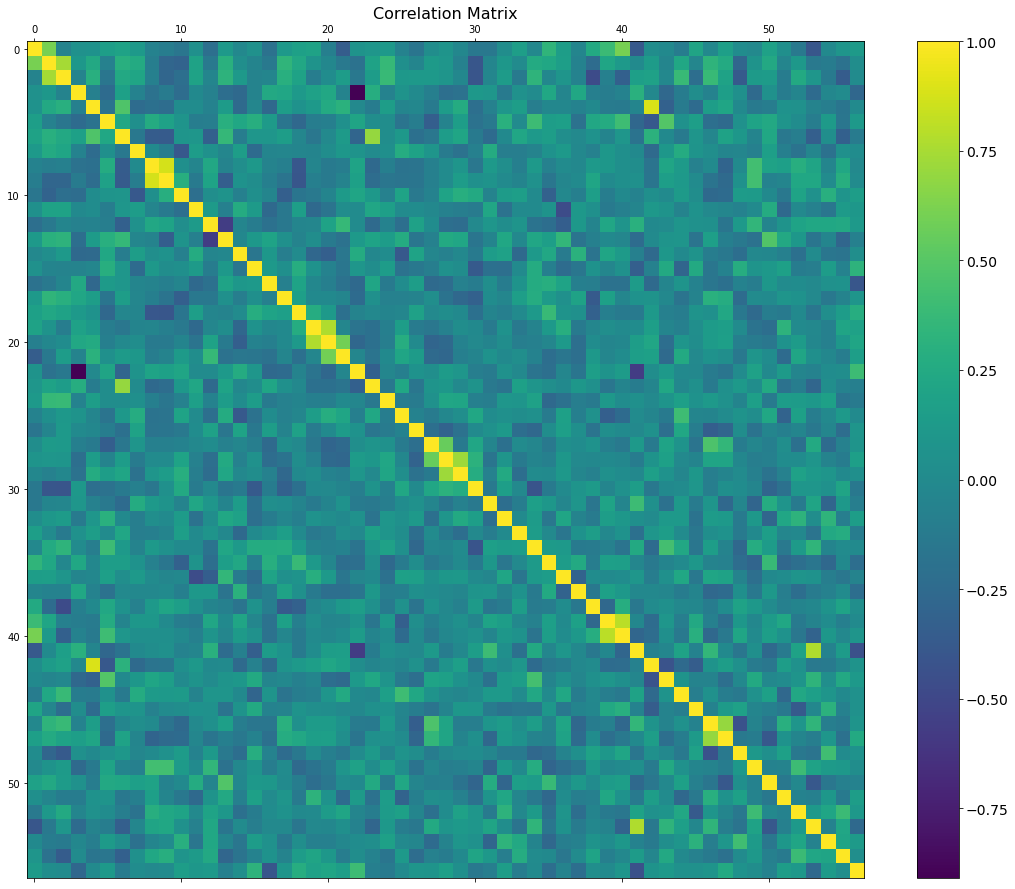

In [21]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.savefig('corr_matrix.jpg', dpi=1000)